In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tumor12/archive/pituitary/Tr-pi_0532.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_0282.jpg
/kaggle/input/tumor12/archive/pituitary/Te-pi_0059.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_1401.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_0914.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_0691.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_0972.jpg
/kaggle/input/tumor12/archive/pituitary/Te-pi_0024.jpg
/kaggle/input/tumor12/archive/pituitary/Te-pi_0232.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_0818.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_0463.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_0930.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_1323.jpg
/kaggle/input/tumor12/archive/pituitary/Te-pi_0286.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_1347.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_1354.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_0704.jpg
/kaggle/input/tumor12/archive/pituitary/Tr-pi_0789.jpg
/kaggle/in

In [2]:
import numpy as np
import os
import cv2
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, BatchNormalization
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Constants
img_size = 224
data_path = '/kaggle/input/tumor12/archive'
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
N_FOLDS = 5

# Load and preprocess data
X = []
Y = []
for c in classes:
    path = os.path.join(data_path, c)
    class_num = classes.index(c)
    for img in os.listdir(path):
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_arr = cv2.resize(img_arr, (img_size, img_size))
        X.append(img_arr)
        Y.append(class_num)

X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y, num_classes=len(classes))

2024-09-07 08:24:19.458421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 08:24:19.458483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 08:24:19.460041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


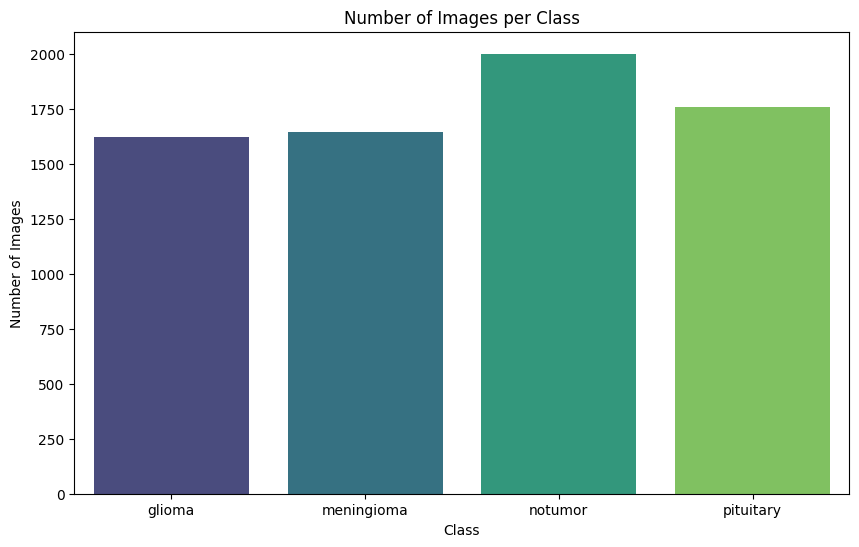

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
class_counts = Counter(Y.argmax(axis=1))  # Extracting the class indices from one-hot encoded labels and counting
# Map class indices back to class names for better readability in the plot
class_names_counts = {classes[k]: v for k, v in class_counts.items()}
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_names_counts.keys()), y=list(class_names_counts.values()), palette='viridis')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [4]:
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Concatenate, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l1_l2
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3


kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

fold_accuracies = []
fold_losses = []

for fold, (train_index, val_index) in enumerate(kf.split(X), start=1):
    print(f"Processing fold {fold}/{N_FOLDS}...")
    
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    # Load pre-trained models
    base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    reg = l1_l2(l1=0.0001, l2=0.0001)

    # Define model architecture
    x1 = base_model1.output
    x1 = GlobalAveragePooling2D()(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dense(1024, activation='relu', kernel_regularizer=reg)(x1)
    x1 = Dropout(0.7)(x1)

    x2 = base_model2.output
    x2 = GlobalAveragePooling2D()(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dense(1024, activation='relu', kernel_regularizer=reg)(x2)
    x2 = Dropout(0.7)(x2)

    combined = Concatenate()([x1, x2])
    combined = BatchNormalization()(combined)
    combined = Dense(1024, activation='relu', kernel_regularizer=reg)(combined)
    combined = Dropout(0.7)(combined)

    predictions = Dense(len(classes), activation='softmax')(combined)

    model = Model(inputs=[base_model1.input, base_model2.input], outputs=predictions)

    for layer in base_model1.layers:
        layer.trainable = False
    for layer in base_model2.layers:
        layer.trainable = False

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Train the model
    history = model.fit(
        [X_train, X_train],  # Provide two inputs
        Y_train,
        batch_size=32,
        epochs=20,
        verbose=1,
        validation_data=([X_val, X_val], Y_val),
        callbacks=[early_stopping]
    )

Processing fold 1/5...
Epoch 1/20


I0000 00:00:1725697557.335905     411 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1725697557.399012     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725697557.404085     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4635 - loss: 12.8646

W0000 00:00:1725697631.331697     413 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725697631.337608     413 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725697639.150564     410 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725697693.988168     410 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 201s 783ms/step - accuracy: 0.4640 - loss: 12.8624 - val_accuracy: 0.8512 - val_loss: 11.5489
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 252ms/step - accuracy: 0.7148 - loss: 11.9115 - val_accuracy: 0.8911 - val_loss: 11.2741
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 258ms/step - accuracy: 0.7875 - loss: 11.5125 - val_accuracy: 0.8996 - val_loss: 11.0722
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8092 - loss: 11.2982 - val_accuracy: 0.9039 - val_loss: 10.8684
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8284 - loss: 11.0466 - val_accuracy: 0.9103 - val_loss: 10.6583
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 256ms/step - accuracy: 0.8461 - loss: 10.8152 - val_accuracy: 0.9167 - val_loss: 10.4424
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 256ms/step - accuracy: 0.8567 - loss: 10.5663 - val_accuracy: 0.9160 - val_loss: 10.2182
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 257ms/step - accuracy: 0.8704 - los

W0000 00:00:1725698573.886058     412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725698573.891529     412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.4657 - loss: 12.8782

W0000 00:00:1725698619.637694     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725698619.643129     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725698626.614599     412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725698638.471708     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 371ms/step - accuracy: 0.4663 - loss: 12.8757 - val_accuracy: 0.8377 - val_loss: 11.5558
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 46s 263ms/step - accuracy: 0.7331 - loss: 11.8399 - val_accuracy: 0.8762 - val_loss: 11.2466
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 254ms/step - accuracy: 0.7896 - loss: 11.4986 - val_accuracy: 0.8890 - val_loss: 11.0311
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 258ms/step - accuracy: 0.8153 - loss: 11.2488 - val_accuracy: 0.9011 - val_loss: 10.8129
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8228 - loss: 11.0249 - val_accuracy: 0.9096 - val_loss: 10.5938
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8469 - loss: 10.7626 - val_accuracy: 0.9160 - val_loss: 10.3691
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 256ms/step - accuracy: 0.8653 - loss: 10.4831 - val_accuracy: 0.9110 - val_loss: 10.1490
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 257ms/step - accuracy: 0.8789 - loss

W0000 00:00:1725699519.537976     412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725699519.543179     412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.4582 - loss: 12.8671

W0000 00:00:1725699565.405992     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725699565.411718     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725699573.152821     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725699584.882465     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 375ms/step - accuracy: 0.4589 - loss: 12.8646 - val_accuracy: 0.8605 - val_loss: 11.5163
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 46s 262ms/step - accuracy: 0.7126 - loss: 11.8801 - val_accuracy: 0.8797 - val_loss: 11.2710
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 253ms/step - accuracy: 0.7666 - loss: 11.5883 - val_accuracy: 0.8804 - val_loss: 11.0661
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 256ms/step - accuracy: 0.8166 - loss: 11.2708 - val_accuracy: 0.8982 - val_loss: 10.8335
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8326 - loss: 11.0128 - val_accuracy: 0.9096 - val_loss: 10.6147
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8515 - loss: 10.7410 - val_accuracy: 0.9132 - val_loss: 10.3960
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8592 - loss: 10.5054 - val_accuracy: 0.9196 - val_loss: 10.1597
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8587 - loss

W0000 00:00:1725700463.381986     412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725700463.387361     412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4527 - loss: 12.9728

W0000 00:00:1725700540.440749     413 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725700540.446343     413 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725700547.520913     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725700601.192948     413 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 157s 790ms/step - accuracy: 0.4534 - loss: 12.9700 - val_accuracy: 0.8241 - val_loss: 11.6032
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 253ms/step - accuracy: 0.7174 - loss: 11.8513 - val_accuracy: 0.8775 - val_loss: 11.2791
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 256ms/step - accuracy: 0.7797 - loss: 11.5204 - val_accuracy: 0.8853 - val_loss: 11.0669
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8143 - loss: 11.2490 - val_accuracy: 0.9053 - val_loss: 10.8400
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 254ms/step - accuracy: 0.8360 - loss: 11.0078 - val_accuracy: 0.9138 - val_loss: 10.6123
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8552 - loss: 10.7463 - val_accuracy: 0.9209 - val_loss: 10.3832
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8596 - loss: 10.4812 - val_accuracy: 0.9174 - val_loss: 10.1582
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8602 - los

W0000 00:00:1725701519.208485     410 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725701519.213555     410 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.4566 - loss: 12.8847

W0000 00:00:1725701565.046381     412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725701565.051946     412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725701572.160396     412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725701583.932157     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 372ms/step - accuracy: 0.4573 - loss: 12.8823 - val_accuracy: 0.8583 - val_loss: 11.5393
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 46s 262ms/step - accuracy: 0.7406 - loss: 11.8171 - val_accuracy: 0.8882 - val_loss: 11.2749
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 253ms/step - accuracy: 0.7799 - loss: 11.5351 - val_accuracy: 0.8839 - val_loss: 11.0891
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 256ms/step - accuracy: 0.8077 - loss: 11.2991 - val_accuracy: 0.9095 - val_loss: 10.8652
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.8269 - loss: 11.0478 - val_accuracy: 0.9117 - val_loss: 10.6543
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 260ms/step - accuracy: 0.8403 - loss: 10.8017 - val_accuracy: 0.9138 - val_loss: 10.4324
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 253ms/step - accuracy: 0.8706 - loss: 10.5137 - val_accuracy: 0.9274 - val_loss: 10.2029
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 257ms/step - accuracy: 0.8687 - loss

In [5]:
    # Evaluate the model
val_loss, val_accuracy = model.evaluate([X_val, X_val], Y_val, verbose=1)
fold_losses.append(val_loss)
fold_accuracies.append(val_accuracy)
print(f"Fold {fold} - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.9235 - loss: 6.8947
Fold 5 - Loss: 6.8584, Accuracy: 0.9444


In [6]:
# Print average results across all folds
print(f"Average Loss: {np.mean(fold_losses):.4f}")
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")

Average Loss: 6.8584
Average Accuracy: 0.9444


In [7]:
# Predict probabilities for the entire dataset
pred_probs = model.predict([X, X], verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)

# Classification report for the entire dataset
true_classes = np.argmax(Y, axis=1)
report = classification_report(true_classes, pred_classes, target_names=classes)
print(f'Overall Classification Report:\n{report}')

  2/220 ━━━━━━━━━━━━━━━━━━━━ 43s 199ms/step

W0000 00:00:1725703010.003138     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


220/220 ━━━━━━━━━━━━━━━━━━━━ 83s 350ms/step


W0000 00:00:1725703086.623403     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Overall Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.96      0.97      1621
  meningioma       0.95      0.94      0.95      1645
     notumor       0.99      1.00      1.00      2000
   pituitary       0.97      0.99      0.98      1757

    accuracy                           0.97      7023
   macro avg       0.97      0.97      0.97      7023
weighted avg       0.97      0.97      0.97      7023

